# Exploratory Data Analysis

## Libraries

In [14]:
import sys
import os
import pandas as pd
import plotly.express as px
import wordcloud
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
sys.path.append((os.path.dirname(os.getcwd())))

from utils.text_processing import counting
from utils.text_processing import make_weighted_table

## Loading data

In [3]:
raw_df = pd.read_csv('../data/raw/pubmed_data.csv')

## Descriptive analysis of the data

In [4]:
raw_df = raw_df.rename(columns={'Unnamed: 0': 'ID'})
raw_df['Year'] = raw_df['Year'].convert_dtypes(convert_integer=True)
raw_df.head()

,ID,Title,Abstract,Journal,Language,Year,Month
0,0,Short and curly.,No Abstract,The Medical journal of Australia,eng,2000,1.0
1,1,Association of androgenetic alopecia and sever...,[StringElement('To establish the association o...,Journal of cosmetic dermatology,eng,2022,3.0
2,2,[On the glucocorticoid treatment of alopecia a...,No Abstract,Asthetische Medizin,ger,1967,5.0
3,3,Epidermal naevus syndrome--a case report.,['A case of epidermal naevus syndrome in a 25-...,Journal of the Indian Medical Association,eng,2003,8.0
4,4,Colored Polymeric Nanofiber Loaded with Minoxi...,['Polymeric nanofibers fabricated by electrosp...,Scientific reports,eng,2020,3.0


In [5]:
fig = px.line(raw_df.groupby(['Year'], as_index=False)['Title'].count(),
                x = 'Year',
                y = 'Title',
                title='Publications per Year',
                labels = {
                    "Year": "Year",
                    "Title": "Number of publications"
                }
)
fig.update_layout(
    title={
        'text': "Publications per Year",
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'
    }
)
fig.show()

In [8]:
words = ['conclusions', 'method', 'alopecia','label', 'disease', 'used', 'patient', 'patients', 'attributes', 'study', 'studies', 'common', 'nlmcategory','abstract','included','significantly','months','increased','compared','attributeslabel','hair','background','observed','methods','may','association','found','results','also','cases','objective','95','using','significant','however','stringelementthe','effects','reported','1','associated','group','clinical','conclusion','data','including','diseases','age','2','ci','unassigned','showed','case','review','analysis','two','case','use','higher','years','diagnosis','levels']
synonyms = [['Androgenetic Alopecia','AA','AGA'],['finasteride','finasterida'],['therapy','treatment'],['adverse effects','adverse']]

In [9]:
bows = counting(raw_df, 'Abstract', words = words, synonyms = synonyms)
df_bow = bows[0]
bow = bows[1]
feature_names = bows[2]

In [10]:
df_weighted = make_weighted_table(bow, feature_names)
df_weights = df_weighted[0]
df_tfidf = df_weighted[1]

In [11]:
s_word_freq = pd.Series(df_weights['count'])
s_word_freq.index = df_weights['word']
di_word_freq = s_word_freq.to_dict()

cloud_whole_period = wordcloud.WordCloud(width=900, height=500, random_state=4, background_color='white',colormap='magma',max_words=15).generate_from_frequencies(di_word_freq)

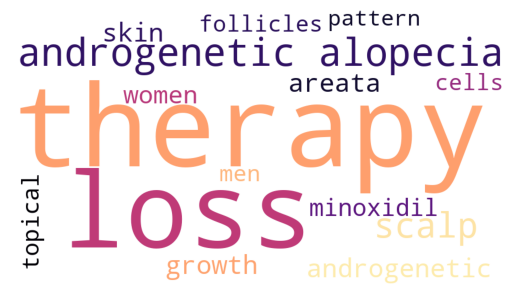

In [12]:
plt.imshow(cloud_whole_period)
plt.axis('off')
plt.show()

In [13]:
raw_df.to_csv('../data/interim/post_eda.csv', index=False) 

# Evolution of the topic research.

### Bow

In [ ]:
df_bow_with_date = pd.concat([raw_df['Year'],df_bow])
df_bow_with_date.dropna(subset=['Year'], inplace=True)
df_bow_with_date['Year'] = df_bow_with_date['Year'].to_numeric(format='%Y')

In [ ]:
bow_by_year = df_bow_with_date.groupby(pd.Grouper(key='Year', axis = 0, freq='Y')).sum()

In [ ]:
bow_cumsum = bow_by_year.cumsum()

### TF-IDF

In [ ]:
df_tfidf_with_date = pd.concat(raw_df['Year'], df_tfidf, axis=1)
df_tfidf_with_date.dropna(subset=['Year'], inplace=True)
df_tfidf_with_date['Year'] = df_bow_with_date['Year'].to_numeric(format='%Y')

In [ ]:
tfidf_by_year = df_tfidf_with_date.groupby(pd.Grouper(key='Year', axis = 0, freq='Y')).mean()